# Using the lcvr_learning Class to Measure Training Data

To train our model, it helps to have a large amount of training data. While this can be measured and calibrated by hand, it can take several hours for a single wavelength to get the data. On top of this, changing the orientation of the LCVR's will then change the necessary driving voltage for different polarizations, resulting in prior training data being useless. To combat this, the class has an automated function for collecting training data.

First we need to import the library. In addition, we set the device to our input channel on our ADC module. This is required to know where the data is being read from. We can also set the function generator being used for the square wave as well, which *should* work so long as it follows the same SCPI command syntax as the Siglent 2042x. Otherwise the functions that read and write parameters to the function generators may need to be modified.

In [1]:
import lcvr_learning as lcl
import numpy as np
import pyvisa
import pandas as pd
import matplotlib.pyplot as plt
rm = pyvisa.ResourceManager('@py')
lcvrs = lcl.lcvr_learning(0x6a,0x6b)

There's a few functions in the class that simplify some processes, such as setting the input voltage, getting information on the current inputs, and reading out data from the ADC. This just cuts back a bit on SCPI queries and hopefully makes the code more readable. As an example:

In [2]:
lcvrs.get_voltage()

9.375e-05

Returns the current output voltage on the ADC, and

In [15]:
lcvrs.get_wave_info(1)
lcvrs.get_wave_info(2)

(2000.0, 1.0)

Returns the frequency and amplitude of the inputs on channel 1 and 2 respectively. These are initialized to 2000 Hz and 1 V when the connection is made as a safeguard. 

# Automatically Reading and Writing Data:

The class has the function get_training_data(iterations,wavelength), which will automatically alter the input voltages on each LCVR and read the differential output on two photodetectors that are preceeded by a Wollaston prism. This in turn means the output voltage is directly correlated to the polarization state of the output light. All of this data is then written to a pandas dataframe for easy manipulation.

In [7]:
data = lcvrs.get_training_data(375,480,mode = "fixed_v1", v1 = 4.8581)

Starting training data scan. Don't touch anything please


In [5]:
data.head()

,Wavelength,V1,V2,Gain,Out
0,480,4.8581,0.600000,1,-0.033141
1,480,4.8581,0.647236,1,0.013000
2,480,4.8581,0.694472,1,0.072953
3,480,4.8581,0.741709,1,0.126484
4,480,4.8581,0.788945,1,0.127062


Here we write the data to a .csv file to train our model on later. The name is simply the wavelength of light used (in nm) to try and keep things readable.

In [8]:
data.to_csv('training_data/single_wave/480_single_v1.csv')

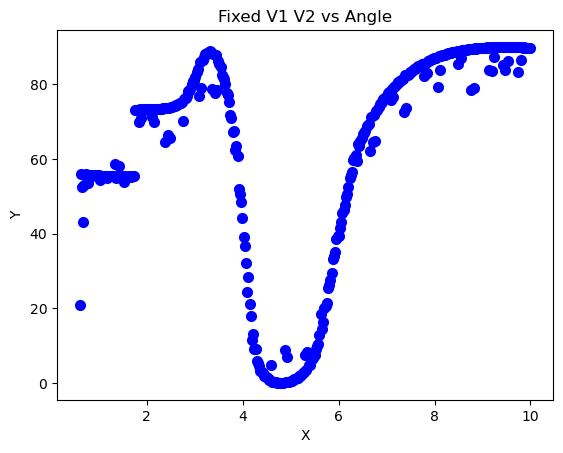

In [6]:
ang_data = pd.read_csv("training_data/single_wave/480_single_v1.csv")
data = lcvrs.add_angle(ang_data)
x = data['V2']
y = data['Angle']

fig, ax = plt.subplots()

ax.scatter(x, y, color='blue', linewidth=2)

# Customization
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Fixed V1 V2 vs Angle')

# Show!
plt.show()

In [3]:
ang_data

,Unnamed: 0,Wavelength,V1,V2,Gain,Out
0,0,480,4.8581,0.600000,1,-0.239844
1,1,480,4.8581,0.625134,1,0.117156
2,2,480,4.8581,0.650267,1,0.080047
3,3,480,4.8581,0.675401,1,-0.013781
4,4,480,4.8581,0.700535,1,0.086453
...,...,...,...,...,...,...
370,370,480,4.8581,9.899465,1,0.458719
371,371,480,4.8581,9.924599,1,0.459125
372,372,480,4.8581,9.949733,1,0.458125
373,373,480,4.8581,9.974866,1,0.457984


In [8]:
data = lcvrs.get_training_data(350,480,mode = "fixed_v1", v1 = 4.8581)

Starting training data scan. Don't touch anything please


/usr/lib/python3/dist-packages/pyvisa_py/protocols/usbtmc.py:115: UserWarning: Unexpected MsgID format. Consider updating the device's firmware. See https://github.com/pyvisa/pyvisa-py/issues/20
  warnings.warn(


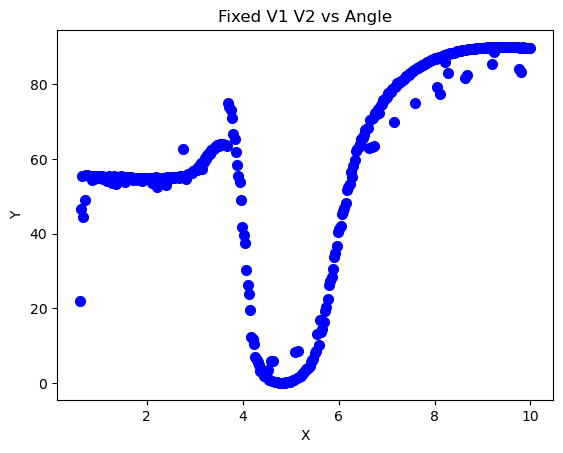

In [9]:
data = lcvrs.add_angle(data)
x = data['V2']
y = data['Angle']

fig, ax = plt.subplots()

ax.scatter(x, y, color='blue', linewidth=2)

# Customization
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Fixed V1 V2 vs Angle')

# Show!
plt.show()